# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE THE PROBLEM

### Can we predict the salaries of the job postings?
Given the previous history of job postings and salaries can we predict the future salary of a job posting.
#### --> Goals (What are we trying to achieve through this project)
    -> Help Companies hire the right candities at the right salary
    -> Help employees get a realistic estimate on the salary of their job

In [1]:
#import your libraries

#Analysis Libraries
import pandas as pd
import numpy as np
import os
import sys

sys.path.insert(1, '../src')

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from visualization import visualize as viz

#Pre processing
from features import build_features as bf

#Models
from models import train_model as tm
from models import predict_model as pm

#Sklearn learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#Info
__author__ = "Saitejas Mopuri"
__email__ = "saitejasmopuri@gmail.com"

## Part 2 - DISCOVER (EDA)

### ---- Loading the data ----

In [2]:
#loading the data into a Pandas dataframe
train_features = pd.read_csv('../data/external/train_features.csv')
train_salaries = pd.read_csv('../data/external/train_salaries.csv')

In [3]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


### --Initial analysis of the data--

we have 8 columns and 2 of them are id columns which might not have any realation with the other columns.

In [5]:
#Number of training examples
train_features.count()

jobId                  1000000
companyId              1000000
jobType                1000000
degree                 1000000
major                  1000000
industry               1000000
yearsExperience        1000000
milesFromMetropolis    1000000
dtype: int64

In [6]:
train_salaries.count()

jobId     1000000
salary    1000000
dtype: int64

The number of train_feature entries match with the number of train_salaries entries 
which is good news.

### ----Cleaning the data ----

In [7]:
train_features.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [8]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [9]:
train_salaries[train_salaries['salary'] == 0]

,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


We have five examples with 0 salaries we are just going to drop them


In [10]:
#Before we drop them let's merge the salaries with 
# features that way we can get rid of the five examples in the 
# features as well
complete_df = pd.concat([train_features, train_salaries['salary']], axis=1)
complete_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [11]:
#Removing the zero salaries
complete_df = complete_df[complete_df.salary != 0]
complete_df.count()

jobId                  999995
companyId              999995
jobType                999995
degree                 999995
major                  999995
industry               999995
yearsExperience        999995
milesFromMetropolis    999995
salary                 999995
dtype: int64

In [12]:
#Checking for null values
complete_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

Awesome no null values

### ---- Data Visualization ----

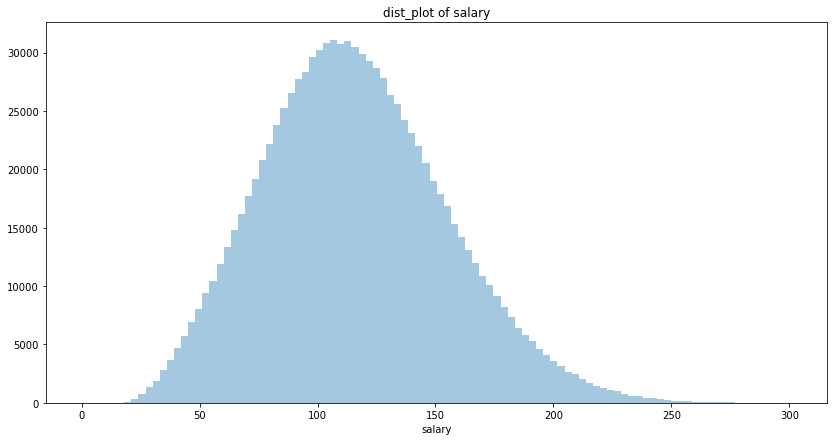

In [13]:
#Checking out the distribution of the salary range
viz.visualization_plot(feature_x='salary', data=train_salaries, plot_type='dist')

We have more salaries around the range of 100 to 150 compared to 50-100 and 150-200

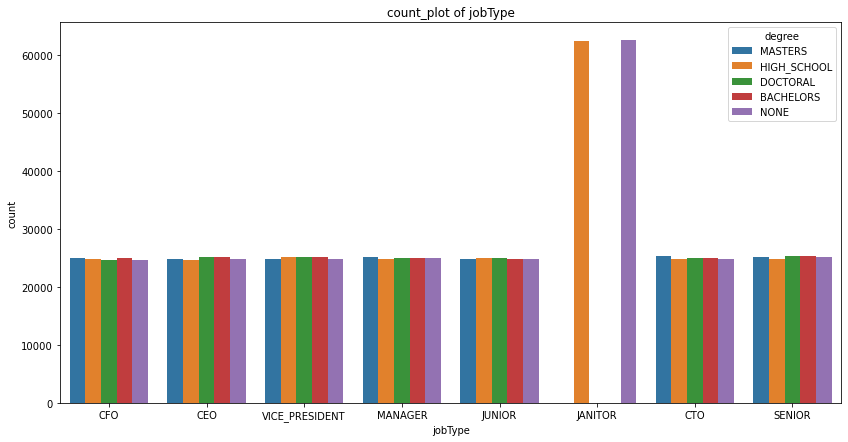

In [14]:
#My hypothesis is that to be a CFO of a company you need at least a 
#masters maybe they forgot to mention the requirment of the degree
viz.visualization_plot(feature_x='jobType', hue='degree', data=complete_df, plot_type='count')

##### My hypothesis was wrong someone with high school diploma can become CEO or CFO

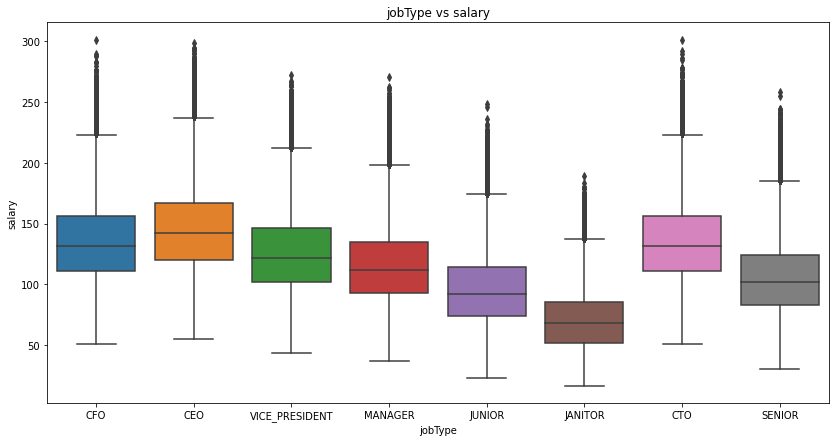

In [15]:
#Lets checkout the distribution of the job type in respect to salary
viz.visualization_plot(feature_x="jobType",feature_y="salary", data=complete_df, plot_type='box')

##### It looks like the CTO and CEO gets paid more than everyone else and the janitor is lowest among all.

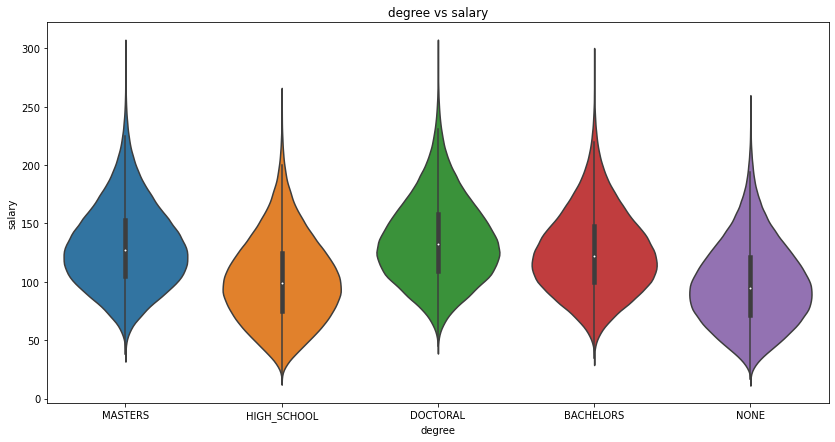

In [16]:
#Lets checkout the distribution of the degree in respect to salary
viz.visualization_plot(feature_x='degree', feature_y='salary', data=complete_df, plot_type='violin')

##### The Doctoral and Masters majors on average get paid more than the bachelors. It looks like the NONE adn Highs Schools get paid the least.

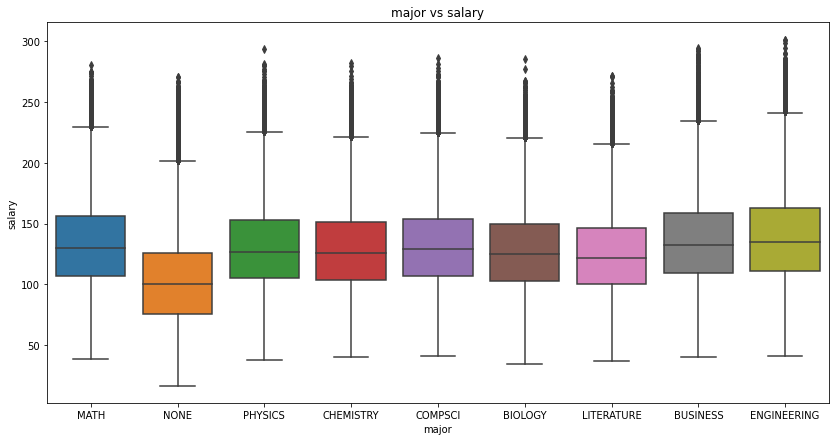

In [17]:
#Checking out the distribution of major in respect to salary
viz.visualization_plot(feature_x='major', feature_y='salary', data=complete_df, plot_type='box')

##### It looks like the jobs that are missing the major requirment pay a little less compared to the one the have the required major type.

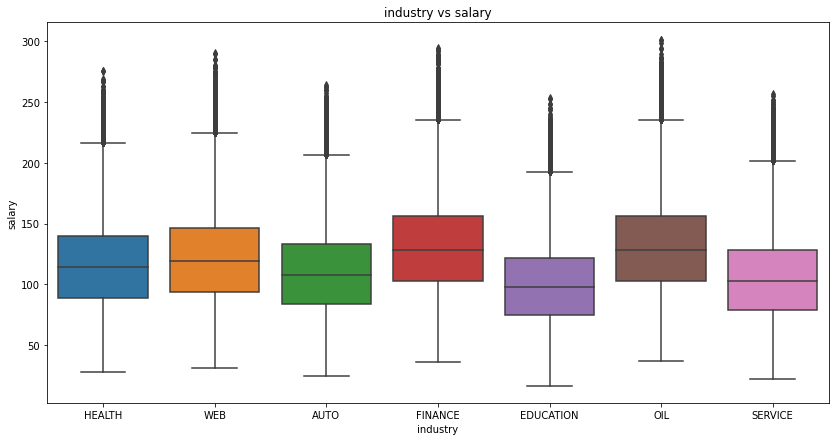

In [18]:
viz.visualization_plot(feature_x='industry',feature_y='salary',data=complete_df, plot_type='box')

##### Looks like the finance majors make a little more money than other industries this would be a good baseline to establish

In [19]:
complete_df.corr()

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


##### We can see a very strong positive corelation with salary and years of expereince

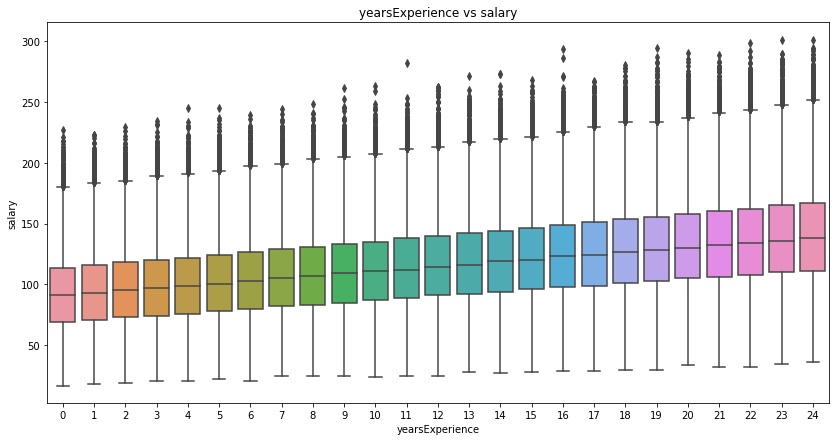

In [20]:
viz.visualization_plot(feature_x='yearsExperience', feature_y='salary', 
                   data=complete_df, plot_type='box')

#### As the number of years goes up the avergage salary goes up. There is a 0.375 postive corelation

### ---- Establishing a baseline ----

In [21]:
baseline_df = complete_df.groupby(by='industry').mean()
baseline_df = baseline_df.drop(labels='milesFromMetropolis', axis=1)
baseline_df = baseline_df.rename(columns={'salary':'avg_salary'})
baseline_df = pd.merge(complete_df, baseline_df, on='industry')
baseline_df = baseline_df[['salary', 'avg_salary']]
error = mean_squared_error(baseline_df['avg_salary'], baseline_df['salary'])
error = round(error, 2)
print('The baseline model mean squared error : {}'.format(error))

The baseline model mean squared error : 1367.12


#### MSE of 1367.12 is what we are trying to beat

### ---- Hypothesize solution ----

In [26]:
#brainstorming couple of models that I think may improve results over the baseline model based
#on my hypothesis 
#1.XGBoost regressor
#2. Densly connected neural network with Hyperparameter tuning

## Part 3 - DEVELOP

### ---- Engineering features  ----

In [23]:
#making sure that data is ready for modeling
#creating any new features needed to potentially enhance model

In [5]:
#using pre_processing to clean the data
complete_df = bf.pre_processing(complete_df)
complete_df.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,3,73,101,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,8,17,142,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0


The data is cleaned and in ready to be trained

In [6]:
#Features will be our independent varialbles
features = complete_df.drop(labels='salary', axis=1)
features.head()

,yearsExperience,milesFromMetropolis,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,3,73,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,10,38,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0
3,8,17,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8,16,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [7]:
#salaries will be our dependent variable
salaries = complete_df['salary']
salaries.head()

0    130
1    101
2    137
3    142
4    163
Name: salary, dtype: int64

In [8]:
#We are going to make a 60/20/20 spilt training/validation/test split
job_features_train, job_features_valid,salaries_train, salaries_valid = train_test_split(features, salaries, test_size=0.4, random_state=101)
job_features_valid, job_features_test,salaries_valid, salaries_test = train_test_split(job_features_valid, salaries_valid, test_size=0.5, random_state=101)

In [9]:
print(job_features_train.count()[0])
print(job_features_valid.count()[0])
print(job_features_test.count()[0])

599997
199999
199999


In [10]:
#Using MinMaxScaler to standardize the features
scaler = MinMaxScaler()
job_features_train.loc[:,['yearsExperience', 'milesFromMetropolis']] = scaler.fit_transform(job_features_train[['yearsExperience', 'milesFromMetropolis']])
job_features_train.head()

C:\Users\saitejas\anaconda3\envs\Machine\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,yearsExperience,milesFromMetropolis,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
389454,0.916667,0.141414,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
294485,0.791667,0.020202,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
24786,0.750000,0.666667,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
200555,1.000000,0.676768,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
695035,0.291667,0.303030,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [11]:
job_features_valid.loc[:,['yearsExperience', 'milesFromMetropolis']] = scaler.transform(job_features_valid[['yearsExperience', 'milesFromMetropolis']])
job_features_test.loc[:,['yearsExperience', 'milesFromMetropolis']] = scaler.transform(job_features_test[['yearsExperience', 'milesFromMetropolis']])

In [12]:
job_features_test.head()

,yearsExperience,milesFromMetropolis,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
441689,0.583333,0.939394,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
135217,0.833333,0.464646,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
862936,0.916667,0.232323,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
472325,0.750000,0.666667,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
687500,0.791667,0.838384,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [13]:
job_features_valid.head()

,yearsExperience,milesFromMetropolis,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
187035,0.916667,0.464646,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
603444,0.333333,0.030303,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
41545,0.458333,0.939394,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
751101,0.583333,0.383838,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
660913,0.333333,0.535354,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### ---- Creating models ----

### First model XGBregressor

In [ ]:
#Training the XGBregressor model
n_estimators = [1000, 1500, 2000, 2500, 3000]
learning_rate = [0.1,0.05,0.01, 0.001,0.0001]
result = tm.xgb_model(n_estimators=n_estimators, 
                   learning_rate=learning_rate,
                  training_data=(job_features_train, salaries_train),
                   validation_data=(job_features_valid, salaries_valid),
                  testing_data=(job_features_test, salaries_test),
                    directory='xgb_performance',
                  filename='training_performance')
print(result)

### Second Model Neural Network with Hyperparametertuning

In [ ]:
model_bo = tm.hyper_parameter_search(train_data=(job_features_train,salaries_train),
                                     val_data=(job_features_valid, salaries_valid),
                                     project_name='salary_prediction_hp_search')
history, model_bo = tm.model_fit(model_bo,train_data=(job_features_train,salaries_train),
                                     val_data=(job_features_valid, salaries_valid))

In [ ]:
model_bo.summary()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### ---- Testing models ----

In [ ]:
#Testing the XGBregressor model
n_estimators = [3000]
learning_rate = [0.01]
result = tm.xgb_model(n_estimators=n_estimators, 
                   learning_rate=learning_rate,
                  training_data=(job_features_train, salaries_train),
                   validation_data=(job_features_valid, salaries_valid),
                  testing_data=(job_features_test, salaries_test),
                    directory='xgb_performance',
                  filename='testing_performance')
print(result)
#Best MSE: 357.94
#Best n_estimator and learning_rate: 3000.0,0.01

In [ ]:
#Evaluating hyperband neural network
model_hb.evaluate(job_features_test, salaries_test, verbose=1)
#Best MSE: 364.09
model_hb.save('../src/models/neuralnetowrk_weights/model_hb.h5')

In [ ]:
#Evaluating random search
model_rs.evaluate(job_features_test, salaries_test, verbose=1)
#Best MSE: 361.31
model_rs.save('../src/models/neuralnetowrk_weights/model_rs.h5')

In [ ]:
#Evaluating Bayesian Optimization
model_bo.evaluate(job_features_test, salaries_test, verbose=1)
#Best MSE: 357.39
model_bo.save('../src/models/neuralnetowrk_weights/model_bo.h5')

### ---- Selecting the best model  ----

In [ ]:
#One hidden layer neural network with BayesianOptimization for hyper parameter tuning

## Part 4 - DEPLOY

### ---- Automating pipeline ----

In [14]:
test_features = pd.read_csv('../data/external/test_features.csv')

In [15]:
processed_test_features = bf.preprocessing_pipeline(data = test_features, scaler=scaler)

### ---- Deploying solution ----

In [16]:
pm.making_predictions(processed_test_features, jobId=test_features['jobId'])

,jobId,predicted_salary
0,JOB1362685407687,112.543755
1,JOB1362685407688,93.704002
2,JOB1362685407689,184.568054
3,JOB1362685407690,104.520447
4,JOB1362685407691,114.641663
...,...,...
999995,JOB1362686407682,169.382843
999996,JOB1362686407683,105.918945
999997,JOB1362686407684,54.804760
999998,JOB1362686407685,163.437393


In [28]:
%load_ext watermark

In [31]:
%watermark -a "Saitejas Mopuri" -d -t -v -p numpy,pandas

Saitejas Mopuri 2020-08-20 16:25:45 

CPython 3.8.3
IPython 7.16.1

numpy 1.18.5
pandas 1.0.5


In [30]:
%watermark?